# Sampling: Constructing the Training Corpus

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import random
import pickle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATASETS_PATH = "datasets/"
SMALL_NA_SELECTION = False
SEED = 2023

In [3]:
if SMALL_NA_SELECTION:
    df_articles = pd.read_pickle(DATASETS_PATH + "df_articles_selection.pkl")
else:
    df_articles = pd.read_pickle(DATASETS_PATH + "df_articles.pkl")

In [4]:
df_articles.head()

,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,persons_mentioned,locations_mentioned,content,access_right,content_provider,is_content_available,collections,decade,newsagency_list,newsagencies
0,BDC-1839-01-26-a-i0011,fr,NaN,661,CH,BDC,BDC-1839-01-26-a,6,1,0.0,...,M. Gros|M. TORRENT|M. JORIS,Sion|Maurice|Maurice|Sion|Maurice|Maurice|Sion...,M. le rapporteur fait observer que la discussi...,OpenPublic,SNL,y,"local-hake-W53_TEjk,local-eb-NelrlrGO,local-ke...",1830,[AP],AP
1,BDC-1839-02-04-a-i0003,fr,NaN,715,CH,BDC,BDC-1839-02-04-a,3,1,0.0,...,T. Du|M. Gard|M. de Kalbcrmatten|M. Pottier|M....,NaN,"tont prononces sur le sort de la constitution,...",OpenPublic,SNL,y,"local-hake-W53_TEjk,local-eb-NelrlrGO,local-ke...",1830,[AP],AP
2,BLB-1845-12-28-a-i0001,de,Der Landbote begrüßt seine Leser und erz...,5211,CH,BLB,BLB-1845-12-28-a,"1,2,3,4,5",5,0.0,...,Jeder Zeitung|Herbst der Einzug|Albert Schnyde...,Chur|Chur|Wetter|Chur|Auch|Chur|Schweiz|Schwei...,Der Landbote begrüßt seine Leser und erzahlt w...,OpenPublic,SNL,y,"local-eb-NelrlrGO,local-robu-LlQfys_b,local-eb...",1840,[TASS],TASS
3,BLB-1846-01-31-a-i0002,de,Inland. Mit Kreisschreiben vom 47. diese...,2549,CH,BLB,BLB-1846-01-31-a,"1,2",2,0.0,...,Benedict La-Roche-St|Herkules Oswald von Ilanz...,Basel|Solothurn|Bern|Solothurn|Auch|Dazu|Armen...,Inland . Mit Kreisschreiben vom 47 . dieses ze...,OpenPublic,SNL,y,"local-eb-NelrlrGO,local-robu-LlQfys_b,local-eb...",1840,[Reuters],Reuters
4,BLB-1846-04-18-a-i0002,de,Bekanntmachungen und Anzeigen,1458,CH,BLB,BLB-1846-04-18-a,4,1,0.0,...,Ueber Elias Bnochi von der Buchen|Michel von B...,Chur|Allen|Chur|Meridian|Chur|Chur|Marau|Boden...,Bekanntmachungen und Anzeigen und Herrlichkeit...,OpenPublic,SNL,y,"local-eb-NelrlrGO,local-robu-LlQfys_b,local-eb...",1840,[Reuters],Reuters


# Time frame for sampling: 1840-1999
-> keep only articles within this time frame

In [5]:
len_before = len(df_articles)
df_articles = df_articles.loc[(df_articles["decade"]>=1840) & (df_articles["decade"]<2000)]
len_after = len(df_articles)
print(f"deleted {len_before-len_after} articles ({round((len_before-len_after)/len_before*100)}% of total)")

deleted 303597 articles (11% of total)


# Open questions
- thresholds for article length (min/max) 
- removing newspapers with #articles <50 or <100? removing NZZ!

### Article Length

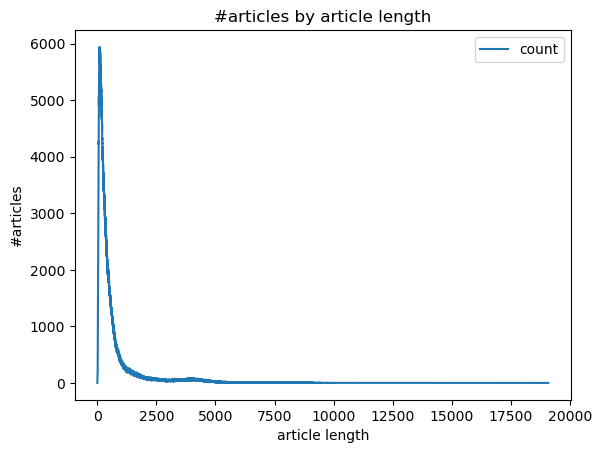

In [6]:
article_sizes = df_articles.groupby("size").count()["uid"].rename("count").reset_index()
article_sizes.plot.line(x="size", y="count", ylabel="#articles", xlabel="article length",
                         title="#articles by article length")
plt.show()

In [7]:
without_nzz = df_articles.loc[df_articles['newspaper'] != "NZZ"]

In [8]:
print(f"Statistics for article lengths:\n{df_articles['size'].describe().apply(lambda x: round(x, 2))}\n\n\
Without NZZ:\n{without_nzz['size'].describe().apply(lambda x: round(x, 2))}")

Statistics for article lengths:
count    2510785.00
mean         655.59
std         1036.62
min            2.00
25%          156.00
50%          310.00
75%          629.00
max        19084.00
Name: size, dtype: float64

Without NZZ:
count    2408348.00
mean         512.59
std          754.20
min            2.00
25%          151.00
50%          294.00
75%          570.00
max        19084.00
Name: size, dtype: float64


In [9]:
percentiles_low = [0.005, 0.01, 0.02, 0.03, 0.05, 0.075, 0.1]
percentiles_high = [0.8, 0.9, 0.925, 0.94, 0.95, 0.97, 0.98, 0.99]
size_percentiles = df_articles[["size"]].quantile(percentiles_low+percentiles_high)
size_percentiles = size_percentiles.join(without_nzz["size"].quantile(percentiles_low+percentiles_high).rename("size_no_NZZ"))

size_percentiles.reset_index(names="percentiles", inplace=True)
size_percentiles.loc[:, "percentiles"] = size_percentiles["percentiles"].apply(lambda x: str(round(x*100,1))+"%")

In [10]:
size_percentiles.iloc[:len(percentiles_low)]

,percentiles,size,size_no_NZZ
0,0.5%,31.0,31.0
1,1.0%,38.0,37.0
2,2.0%,47.0,46.0
3,3.0%,54.0,53.0
4,5.0%,66.0,65.0
5,7.5%,78.0,77.0
6,10.0%,89.0,87.0


In [11]:
print("Articles with length <32\n\n")
for i, content in enumerate(df_articles.loc[df_articles["size"]<32].head(20)["content"]):
    print(f"{i}. {content}")

Articles with length <32


0. ^ ap italanlagyn zu 4 , 412 bis 5 Prozent vermittelt das BanlComptoir von in Seanfs . 
1. DDP— AbonneMents HW aui oie „ Vunoner- « acyricycen nno oeren „ Wochenblatt werden fortwährend angenommen . Erschienene Nummern des „ Alphorn werden gratis nachgeliefert . 
2. M. Torrcnté, de Massongcx, offre à louer un ap partement et un four tout neuf. S'adresser à lui même pour le prix et les conditions. 
3. A LOUER, pour la Si-Martin prochaine, un ap partement, rue de Conthey, à Sion. S'adresser au gérant du journal. SION. — IMPRIMERIE DE DAVID RACHOR 
4. A LOUER, pour la St-Martin prochaine, un ap partement, rue de Conthey, à Sion. S'adresser au gérant du journal. SION. — IMPRIMERIE DE DAVID RACHOR 
5. Konstantinopel. Nach den Informationen des Wolffbureaus hat die Pforte beschlossen, die russische Forderung bezüglich der Oeffnung der Dardanellen zurückzuweisen, da fönst land eine urädominierende Stellung in Konstan 
6. und nahm Referate von Professor Tschirch in

In [12]:
print("Articles with length >=32 and <39\n\n")
for i, content in enumerate(df_articles.loc[(df_articles["size"]>=32) & (df_articles["size"]<39)].head(20)["content"]):
    print(f"{i}. {content}")

Articles with length >=32 and <39


0. QemütlicKer Vereinigung 3 am 8 taß, clen 7. im Dezember l 912 Notel „ LaKnliof" in Ker ^ erg sreun 6 ! icb 8 t laclet ein ttermnnn lirnmer, Wirt ^ ssZI'KMK ^ I'mit 
1. USA Die Rede des Präsidenten Roosevelt Neuyork , 11 . . luni . ( Reuter . ) Präsident Roosevelt hielt arn Montagabend in Charlotteville eine Rede . Er führte u . a . aus , die amerikanische Regie- 
2. Das Tschechische Nationalkomitee In London London , 16 . Juli . ( United Preß . ) Man erwartet hier , daß England noch diese Woche das Tschechische Nationalkomitee in London als legale Regierung der Tschechoslowakei anerkennen werde . 
3. Karfreitag i Ungar . Champignons , Südungarische Eier Karsamstagt Ungarisches Paprika-Huhn Ostersonntag t Slebenbürger Gulasch , Jungfrau-Braten Ostermontag t Tschlkosch Rostbraten , ung . Paprika-Huhn TägUthi Gulasch en tasse ( OC ) , Palasclnta 
4. n 5 h 20 . Ap r ? l ^ ° D < 8 roB Er , ol 9 d * ° » H ( _«» PP » : Feuervogel V . Strawinsky Josephsle

In [13]:
size_percentiles.iloc[len(percentiles_low):]

,percentiles,size,size_no_NZZ
7,80.0%,764.0,669.0
8,90.0%,1487.0,1096.0
9,92.5%,1950.0,1336.0
10,94.0%,2440.0,1529.0
11,95.0%,2907.0,1689.0
12,97.0%,3917.0,2183.0
13,98.0%,4332.0,2574.0
14,99.0%,5084.0,3353.0


In [14]:
print("Articles with length >2500")
df_articles.loc[df_articles["size"]>2600].sample(5, random_state=2023)["uid"]
#> almost all whole pages

Articles with length >2500


2693176    luxwort-1874-06-08-a-i0011
2480464        LSE-1926-02-20-a-i0062
2632258        NZZ-1950-01-08-a-i0002
2577752        NZZ-1926-01-21-c-i0006
2543281        NZZ-1884-09-03-b-i0002
Name: uid, dtype: object

In [15]:
print("Articles with length between 2000 and 2500")
without_nzz.loc[(without_nzz["size"]>2000) & (without_nzz["size"]<2500) ].sample(5, random_state=2023)["uid"]
#> almost all whole pages

Articles with length between 2000 and 2500


2479885    LSE-1925-06-04-a-i0038
2012569    JDG-1992-08-04-a-i0043
652600     FZG-1907-05-02-a-i0022
2127982    LLE-1954-02-26-a-i0010
93905      DTT-1964-08-10-a-i0019
Name: uid, dtype: object

In [16]:
print("Articles with length of 1500")
without_nzz.loc[(without_nzz["size"]==1500) ].sample(5, random_state=2023)["uid"]
#> almost all whole pages

Articles with length of 1500


43882          DTT-1954-03-19-a-i0117
146192         DTT-1974-09-18-a-i0010
2076674        LLE-1912-11-02-a-i0060
2703693    luxwort-1915-08-01-a-i0041
797352         FZG-1990-07-31-a-i0018
Name: uid, dtype: object

### #Articles per Newspaper

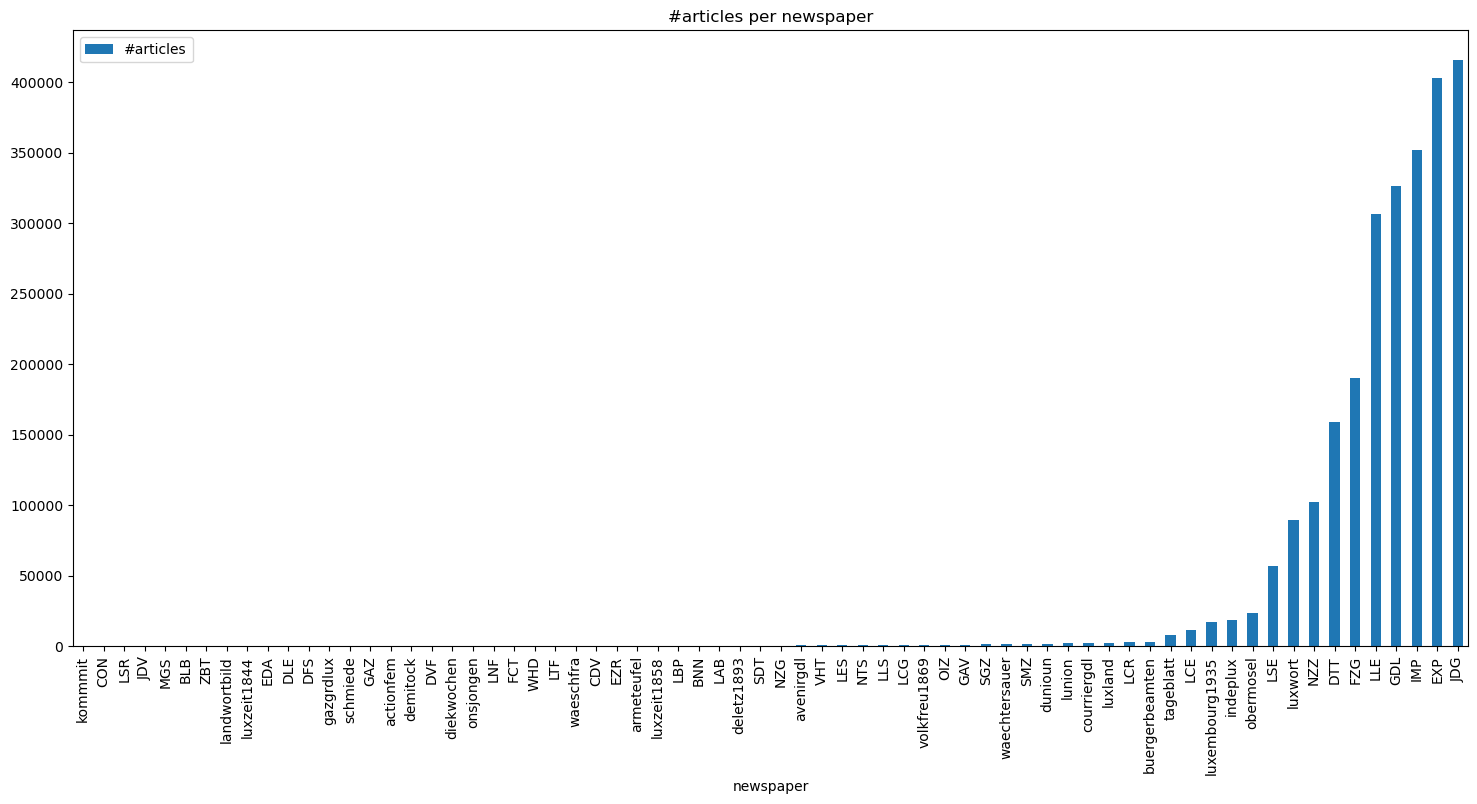

In [17]:
art_per_newspaper = df_articles[["newspaper", "uid"]].groupby("newspaper").count()\
    .rename(columns={"uid":"#articles"}).sort_values("#articles")
art_per_newspaper.plot.bar(figsize=(18,8), title="#articles per newspaper")
plt.show()

In [18]:
print(f"#newspapers in collection: {len(art_per_newspaper)}\n\
#newspapers with <50 articles: {len(art_per_newspaper[art_per_newspaper['#articles']<50])}\n\
            with <75 articles: {len(art_per_newspaper[art_per_newspaper['#articles']<75])}\n\
            with <100 articles: {len(art_per_newspaper[art_per_newspaper['#articles']<100])}\n")
art_per_newspaper.nlargest(25, columns="#articles")

#newspapers in collection: 68
#newspapers with <50 articles: 10
            with <75 articles: 17
            with <100 articles: 20



,#articles
newspaper,
JDG,416005
EXP,402879
IMP,351643
GDL,326501
LLE,306498
FZG,190213
DTT,158873
NZZ,102437
luxwort,89533


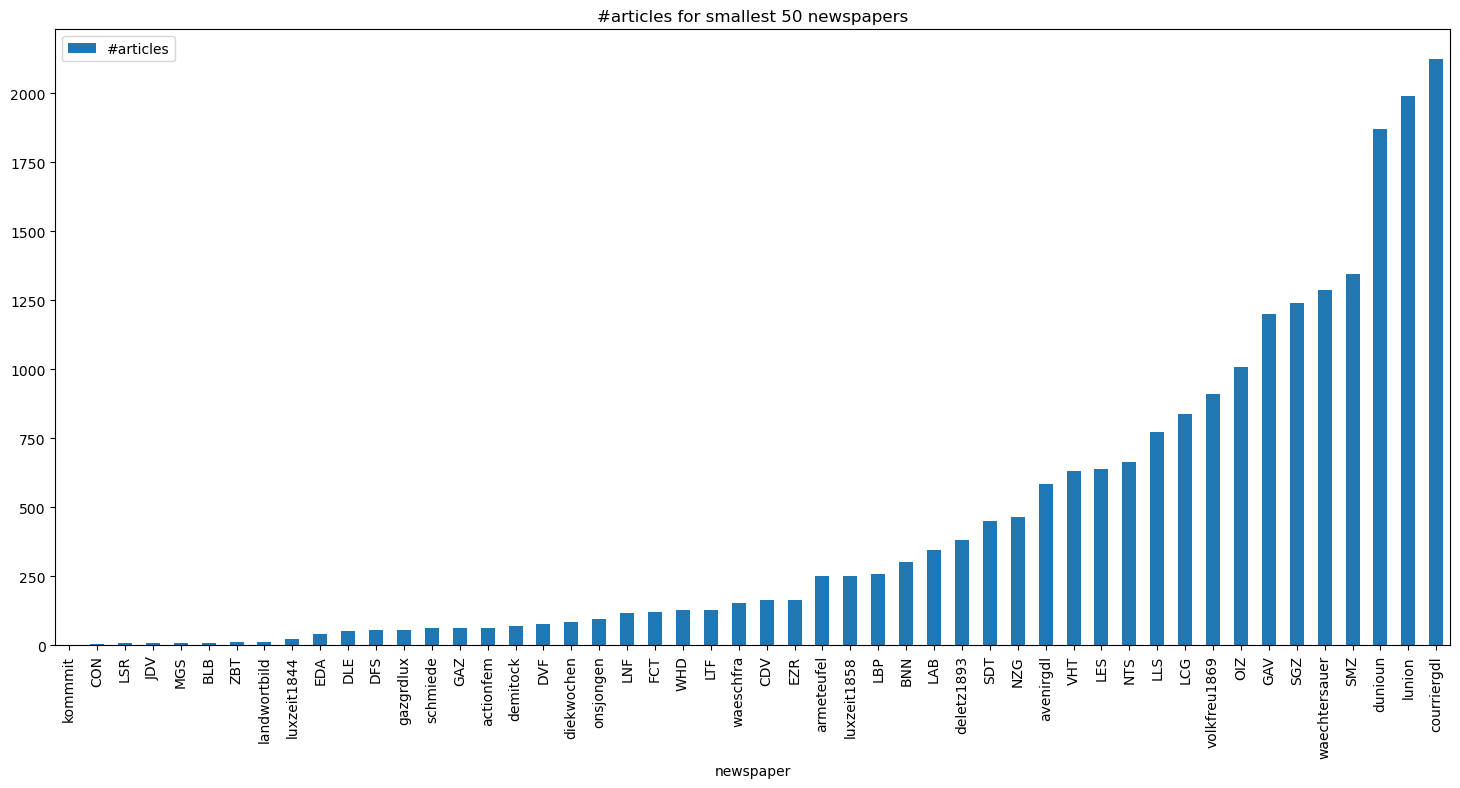

In [19]:
art_per_newspaper.nsmallest(50, "#articles").plot.bar(figsize=(18,8), 
                                            title="#articles for smallest 50 newspapers")
plt.show()

In [20]:
smallest25_names = list(art_per_newspaper.nsmallest(25, "#articles").index)
smallest50_names = list(art_per_newspaper.nsmallest(50, "#articles").index)
smallest25 = df_articles.loc[df_articles["newspaper"].isin(smallest25_names)]
smallest50 = df_articles.loc[df_articles["newspaper"].isin(smallest50_names)]

print(f"#articles in low frequency newspapers: {len(smallest25)}\
    ({round(len(smallest25)/len(df_articles)*100, 2)}% of total collection)\n")

print(f"#articles per country:\n{df_articles['country'].value_counts()}\n\nvs.\n\
#articles per country in low frequency newspapers:\n{smallest25['country'].value_counts()}")

#articles in low frequency newspapers: 1455    (0.06% of total collection)

#articles per country:
CH    2337570
LU     173152
Name: country, dtype: int64

vs.
#articles per country in low frequency newspapers:
CH    767
LU    625
Name: country, dtype: int64


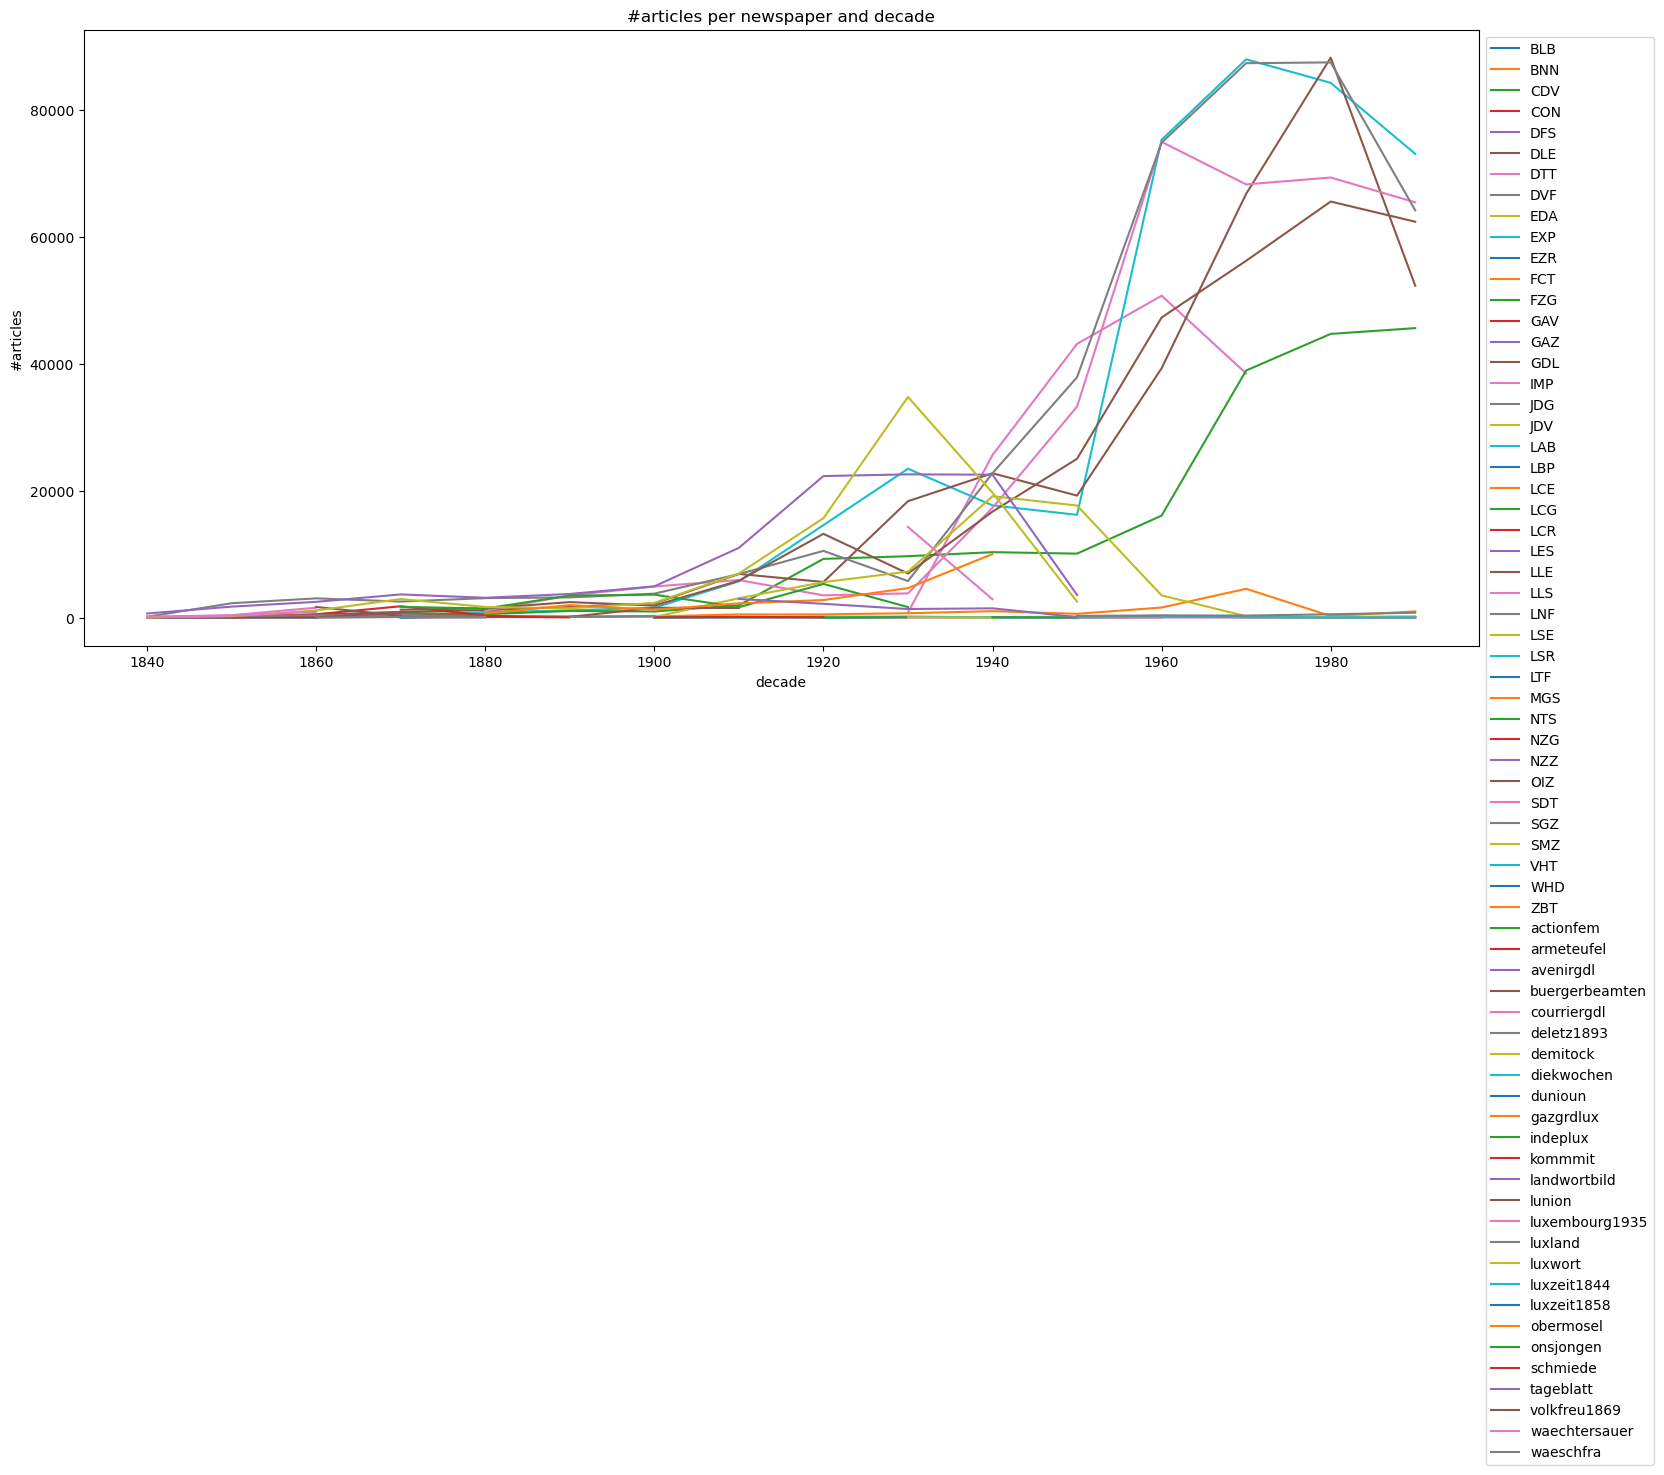

In [21]:
np_per_decade = pd.pivot_table(df_articles, index="decade", columns="newspaper", values="uid", aggfunc="count")
np_per_decade.plot.line(figsize=(18,8), ylabel="#articles", title="#articles per newspaper and decade")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

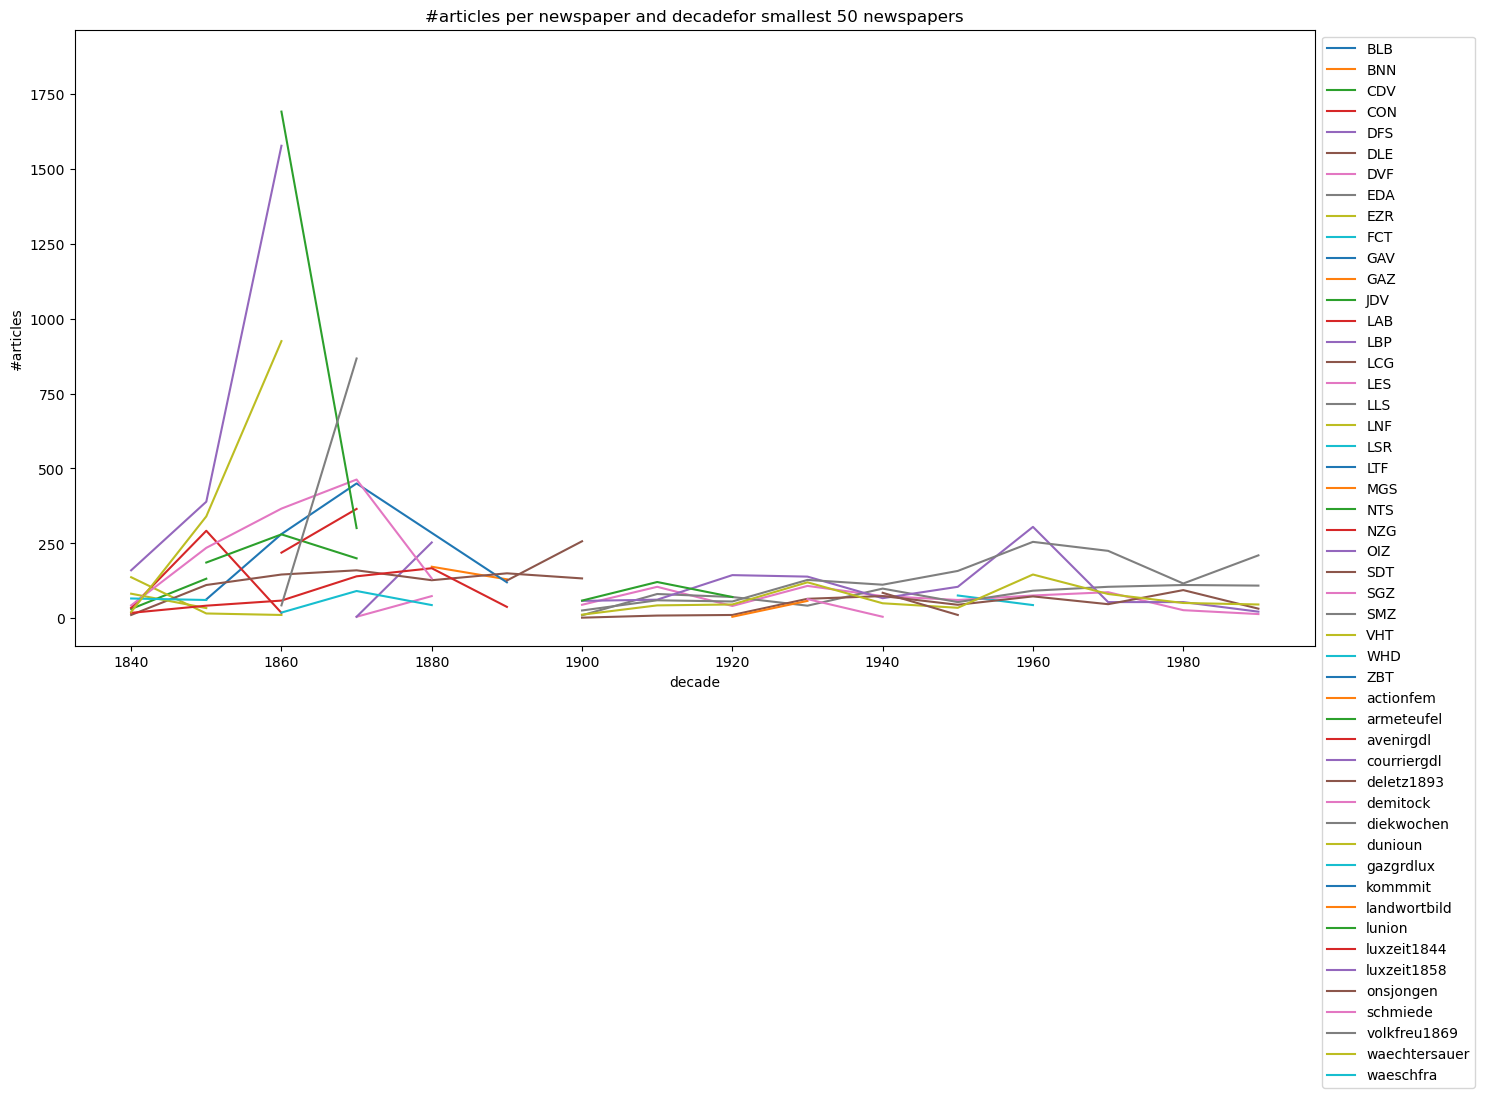

In [22]:
np_per_decade = pd.pivot_table(smallest50, index="decade", columns="newspaper", values="uid", aggfunc="count")
np_per_decade.plot.line(figsize=(16,8), ylabel="#articles", title="#articles per newspaper and decade\
for smallest 50 newspapers")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

### helper function

In [23]:
def get_percent_np_per_decade(df, art_per_newspaper=art_per_newspaper, nlargest=68):
    '''
    get percentage of each newspaper for each decade, for the nlargest newspapers
    '''
    largest_nps = art_per_newspaper.nlargest(nlargest, "#articles").index
    use_df = df[df["newspaper"].isin(largest_nps)]
    np_per_decade = pd.pivot_table(use_df, index="decade", columns="newspaper", values="uid", aggfunc="count")
    np_per_decade.fillna(0, inplace=True)
    articles_per_decade = np_per_decade.sum(axis=1)
    np_per_decade_percent = np_per_decade.divide(articles_per_decade, axis=0)
    
    return np_per_decade_percent

def get_relevant_dict(df, art_per_newspaper=art_per_newspaper, nlargest=68, key="decade"):
    np_per_decade_percent = get_percent_np_per_decade(df, art_per_newspaper=art_per_newspaper, nlargest=nlargest)

    relevant_dict = dict()

    if key == "decade":
        for decade in np_per_decade_percent.index:
            #for each decade, store all newspapers where percentage of articles is >= 1%
            relevant_dict[decade] = [np for np in np_per_decade_percent.columns
                if np_per_decade_percent.loc[decade, np] >= 0.01]
    else:
        for np in np_per_decade_percent.columns:
            #for each newspaper, store all decades where percentage of articles is >= 1%
            relevant_dict[np] = [decade for decade in np_per_decade_percent.index 
               if np_per_decade_percent.loc[decade, np] >= 0.01]
    
    return relevant_dict


In [24]:
dec_all_relevant_np = get_relevant_dict(df_articles)
dec_largest50_np = get_relevant_dict(df_articles, nlargest=50)
dec_largest40_np = get_relevant_dict(df_articles, nlargest=40)

np_all_relevant_dec = get_relevant_dict(df_articles, key="np")    
print("Newspapers in no decade with frequency > 1%:", [np for np in np_per_decade.columns 
                                        if len(np_all_relevant_dec[np])==0])

Newspapers in no decade with frequency > 1%: ['BLB', 'CON', 'DLE', 'DVF', 'FCT', 'JDV', 'LES', 'LLS', 'LSR', 'LTF', 'MGS', 'NZG', 'OIZ', 'SDT', 'SMZ', 'VHT', 'ZBT', 'actionfem', 'armeteufel', 'deletz1893', 'demitock', 'dunioun', 'gazgrdlux', 'kommmit', 'landwortbild', 'onsjongen', 'schmiede', 'waeschfra']


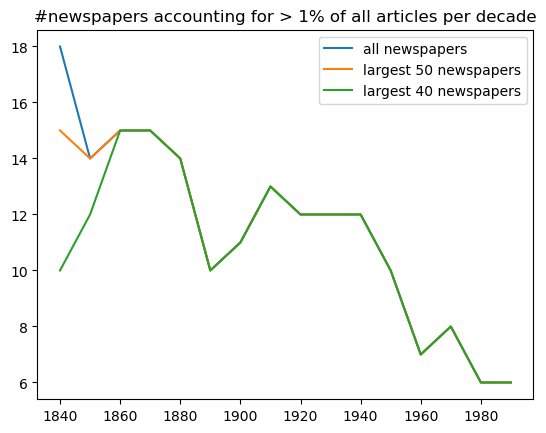

In [25]:
plt.plot(dec_all_relevant_np.keys(), [len(value) for value in dec_all_relevant_np.values()])
plt.plot(dec_largest50_np.keys(), [len(value) for value in dec_largest50_np.values()])
plt.plot(dec_largest40_np.keys(), [len(value) for value in dec_largest40_np.values()])
plt.legend(["all newspapers","largest 50 newspapers","largest 40 newspapers"])
plt.title("#newspapers accounting for > 1% of all articles per decade")
plt.show()

### same without NZZ

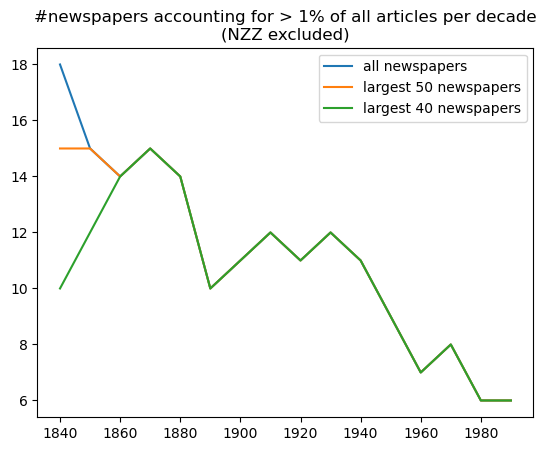

In [26]:
no_nzz_dec_all_relevant_np = get_relevant_dict(without_nzz)
no_nzz_dec_largest50_np = get_relevant_dict(without_nzz, nlargest=50)
no_nzz_dec_largest40_np = get_relevant_dict(without_nzz, nlargest=40)

plt.plot(no_nzz_dec_all_relevant_np.keys(), [len(value) for value in no_nzz_dec_all_relevant_np.values()])
plt.plot(no_nzz_dec_largest50_np.keys(), [len(value) for value in no_nzz_dec_largest50_np.values()])
plt.plot(no_nzz_dec_largest40_np.keys(), [len(value) for value in no_nzz_dec_largest40_np.values()])
plt.legend(["all newspapers","largest 50 newspapers","largest 40 newspapers"])
plt.title("#newspapers accounting for > 1% of all articles per decade\n(NZZ excluded)")
plt.show()

In [27]:
no_nzz_art_per_newspaper = without_nzz[["newspaper", "uid"]].groupby("newspaper").count()\
    .rename(columns={"uid":"#articles"}).sort_values("#articles")

print(f"#newspapers in collection (without NZZ): {len(no_nzz_art_per_newspaper)}\n\
#newspapers with <50 articles: {len(no_nzz_art_per_newspaper[no_nzz_art_per_newspaper['#articles']<50])}\n\
            with <75 articles: {len(no_nzz_art_per_newspaper[no_nzz_art_per_newspaper['#articles']<75])}\n\
            with <100 articles: {len(no_nzz_art_per_newspaper[no_nzz_art_per_newspaper['#articles']<100])}\n")
no_nzz_art_per_newspaper.nlargest(25, columns="#articles")

#newspapers in collection (without NZZ): 67
#newspapers with <50 articles: 10
            with <75 articles: 17
            with <100 articles: 20



,#articles
newspaper,
JDG,416005
EXP,402879
IMP,351643
GDL,326501
LLE,306498
FZG,190213
DTT,158873
luxwort,89533
LSE,56850


### same with threshold for article length already applied

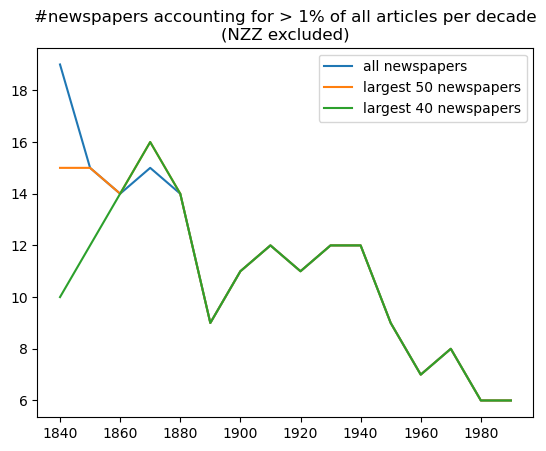

In [28]:
thresholded_df = without_nzz.loc[(df_articles["size"] >= 32) & (df_articles["size"] < 2000)]

thres_dec_all_relevant_np = get_relevant_dict(thresholded_df)
thres_dec_largest50_np = get_relevant_dict(thresholded_df, nlargest=50)
thres_dec_largest40_np = get_relevant_dict(thresholded_df, nlargest=40)

plt.plot(thres_dec_all_relevant_np.keys(), [len(value) for value in thres_dec_all_relevant_np.values()])
plt.plot(thres_dec_largest50_np.keys(), [len(value) for value in thres_dec_largest50_np.values()])
plt.plot(thres_dec_largest40_np.keys(), [len(value) for value in thres_dec_largest40_np.values()])
plt.legend(["all newspapers","largest 50 newspapers","largest 40 newspapers"])
plt.title("#newspapers accounting for > 1% of all articles per decade\n(NZZ excluded)")
plt.show()

## Choosing the Thresholds

In [29]:
#specify thresholds
size_low_thres = 32
size_high_thres = 2000
np_to_drop = list(art_per_newspaper[art_per_newspaper['#articles'] < 75].index)
np_to_drop.append("NZZ")

In [30]:
#applying thresholds
df_to_sample = df_articles.loc[~(df_articles["newspaper"].isin(np_to_drop))]
df_to_sample = df_to_sample.loc[(df_to_sample["size"] >= size_low_thres) & (df_to_sample["size"] < size_high_thres)]

#statistics
print(f"Dropped {round((len(df_articles)-len(df_to_sample))/len(df_articles)*100)}% of all articles, remaining: {len(df_to_sample)}\n\
#newspapers remaining: {len(df_to_sample['newspaper'].unique())}")

Dropped 8% of all articles, remaining: 2308268
#newspapers remaining: 50


## Dealing with multiple news agency mentions per article

In [31]:
#for articles with several news agency mentions, randomly choose one news agency
random.seed(SEED)
df_to_sample["newsagency"] = df_to_sample["newsagency_list"].apply(lambda x: random.choice(x))

In [32]:
df_to_sample.head()

,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,locations_mentioned,content,access_right,content_provider,is_content_available,collections,decade,newsagency_list,newsagencies,newsagency
11,BNN-1886-01-05-a-i0001,de,Ueber Thierschutz,578,CH,BNN,BNN-1886-01-05-a,3,1,0.0,...,Schweiz|Italien|Wetter|Italien|Zürich|Chur,Ueber Thierschutz Aus dem Vortrag des Hrn . Pf...,OpenPublic,SNL,y,"local-hake-W53_TEjk,local-eb-NelrlrGO,local-ke...",1880,[Wolff],Wolff,Wolff
13,BNN-1886-02-13-a-i0003,de,Staatstunde,1276,CH,BNN,BNN-1886-02-13-a,3,1,0.0,...,Forst|Rath|Rath|Rath|Rath|Rath|Rath|Boden|Boden,Staatstunde Ansere forstliche Gesetzgebung . I...,OpenPublic,SNL,y,"local-hake-W53_TEjk,local-eb-NelrlrGO,local-ke...",1880,[Wolff],Wolff,Wolff
14,BNN-1886-04-03-a-i0037,de,"Die „Rhätische Zentealbahn""",1993,CH,BNN,BNN-1886-04-03-a,"1,2",2,0.0,...,Thusis|Thusis|Thusis|Italien|Thusis|Thusis|Thu...,Die „ Rhätische Zentealbahn „ Einsteigen nach ...,OpenPublic,SNL,y,"local-hake-W53_TEjk,local-eb-NelrlrGO,local-ke...",1880,[Reuters],Reuters,Reuters
15,BNN-1886-04-10-a-i0004,de,"«»llen Verwandten, Freunden und Be- Kä^-...",179,CH,BNN,BNN-1886-04-10-a,4,1,0.0,...,NaN,"«» llen Verwandten , Freunden und Be- Kä ^ -N ...",OpenPublic,SNL,y,"local-duma-fwxsqdbO,local-hake-W53_TEjk,local-...",1880,[ANSA],ANSA,ANSA
16,BNN-1886-04-10-a-i0022,de,Zur Gisenbahnfrage,1641,CH,BNN,BNN-1886-04-10-a,1,1,0.0,...,Chur|Italien|Chur|Italien|Italien|Boden|Landes...,Zur Gisenbahnfrage Die wohllöbliche Standeskom...,OpenPublic,SNL,y,"local-duma-fwxsqdbO,local-hake-W53_TEjk,local-...",1880,[TASS],TASS,TASS


# Sampling
- 100 per decade -> 1600 in total
<p>

- Uniformly over Time: 1840-1999 (decade 1840-1990)
- Stratified over News Agencies
- Stratified over Newspapers
<p>

- not considered: country

### sampling functions

#### stratified sampling

In [33]:
'''
https://github.com/flaboss/python_stratified_sampling

This module contains functions that computes stratified sampling of pandas dataframes.
'''
# Required libraries
#import pandas as pd
#import numpy as np
#import warnings
#warnings.filterwarnings("ignore")

# Functions
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    #changed to df.assign to avoid warning
    tmp = tmp.assign(size = 1)
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            #changed append to concat
            stratified_df = pd.concat([stratified_df, tmp_df], ignore_index=True)
    
    return stratified_df


def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    #changed to df.assign to avoid warning
    tmp = tmp.assign(size = 1)
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

#### sampling on a selection of rows

In [34]:
def conditional_sample(df, selection_condition, already_sampled=pd.DataFrame(), n=1, seed=None, keep_index= False):
    '''
    Samples additional rows of df based the specified selection condition (e.g. {"newsagency": "ANSA", "newspaper":"EXP"})

    Parameters
    ----------
        :df: pandas dataframe from which data will be sampled (if already_sampled != None, it needs column with ID named "uid)
        :selection_condition: dictionary specifying which rows should be used for sampling;
                            of the form {column1: criteria1, column2: criteria2, ...}, e.g. {"newsagency": "ANSA", "newspaper":"EXP"}
        :already_sampled: pandas dataframe containing rows which have already been sampled (needs column with ID named "uid) -> will be excluded
        :n: number of samples
        :seed: sampling seed
        :keep_index: if True, it keeps a column with the original population index indicator
    Returns
    -------
    A sampled pandas dataframe based on selection conditions
    '''

    df_selection = df.copy()
    
    #exclude all articles which already have been sampled
    if already_sampled.empty:
        df_selection = df_selection[~(df["uid"].isin(already_sampled["uid"]))]

    #select only rows which fit the selection criteria
    for column, to_select in selection_condition.items():
        df_selection = df_selection[df_selection[column] == to_select]
    
    #sampling
    return df_selection.sample(n=n, random_state=seed).reset_index(drop=(not keep_index))

#### ensuring to sample minimum numbers

In [35]:
def stratified_sample_min_freq(df, strata, min_group_name, min_group_n, size, seed, keep_index=False, report=True):
    ''' 
    Performs stratified sampling based on strata, but ensures that each unique value from column "min_group_name" is in sampled data
    at least "min_group_n" times (e.g. each news agency appears at least 3 times in sampled data).
    '''
    sample = stratified_sample(df=df, strata=strata, size=size, seed=seed, keep_index=keep_index)
    strata_new = strata.copy()
    strata_new.append("uid")
    grouped_df = sample[strata_new].groupby(strata_new)["uid"].count().rename("#articles").reset_index()

    added = dict()
    for agency, freq in grouped_df[min_group_name].value_counts().items():
        if freq < min_group_n:
            add_n = min_group_n - freq
            add_sample = conditional_sample(df, selection_condition={min_group_name: agency}, already_sampled=sample, n=add_n, seed=seed, keep_index=keep_index)
            sample = pd.concat([sample, add_sample], ignore_index=True)
            added[agency] = add_n

    if report:
        return sample, added
    else:
        return sample


def stratified_sample_min_freq_and_size(df, strata, min_group_name, min_group_n, size, seed, keep_index=False):
    ''' 
    Performs stratified sampling with minimum "min_group" frequency (see "stratified_sample_min_freq()") and ensures that the sample
    size is at least the amount specified in "size" (stratified_sample tends to sample a bit less).
    '''
    sample, report = stratified_sample_min_freq(df, strata, min_group_name, min_group_n, size, seed, keep_index, report=True)
    tmp_size = size
    while len(sample) < size:
        tmp_size += 1
        sample, report = stratified_sample_min_freq(df, strata, min_group_name, min_group_n, tmp_size, seed, keep_index, report=True)
    print(f"#samples: {len(sample)}, achieved with sample size = {tmp_size}; articles added to ensure min newsagency frequency: {report}")
    return sample

## Performing the sampling

In [36]:
decades = [1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990]
sample_all = pd.DataFrame()

for decade in decades:
    print("\nSampling for decade:", decade)
    df_dec = df_to_sample[df_to_sample["decade"]==decade]
    sample_dec = stratified_sample_min_freq_and_size(df=df_dec, strata=["newspaper", "newsagency"], min_group_name="newsagency",
                                             min_group_n=3, size=100, seed=SEED)
    sample_all = pd.concat([sample_all, sample_dec], ignore_index=True)


Sampling for decade: 1840
#samples: 100, achieved with sample size = 109; articles added to ensure min newsagency frequency: {'ANSA': 2}

Sampling for decade: 1850
#samples: 100, achieved with sample size = 106; articles added to ensure min newsagency frequency: {'ATS': 2, 'ANSA': 2}

Sampling for decade: 1860
#samples: 100, achieved with sample size = 107; articles added to ensure min newsagency frequency: {'ATS': 1}

Sampling for decade: 1870
#samples: 100, achieved with sample size = 108; articles added to ensure min newsagency frequency: {'Stefani': 1, 'DDP-DAPD': 2}

Sampling for decade: 1880
#samples: 101, achieved with sample size = 110; articles added to ensure min newsagency frequency: {'Stefani': 2}

Sampling for decade: 1890
#samples: 100, achieved with sample size = 105; articles added to ensure min newsagency frequency: {'TASS': 1}

Sampling for decade: 1900
#samples: 100, achieved with sample size = 110; articles added to ensure min newsagency frequency: {}

Sampling for

# Train/Dev/Test Split
for each decade, stratified for news agencies, but not for newspapers

In [37]:
def train_dev_test_split(df, dev_size, test_size, strata, random_state):
    '''
    Splits sampled data in train, dev and test set

    Parameters
    ----------
        :df: pandas dataframe to be split into train, dev and test set
        :dev_size: ratio for size of dev set
        :test_size: ratio for size of test set
        :strata: columns to be considered for stratification
        :random_state: seed for splitting
    Returns
    -------
        :df_train: pandas dataframe for training
        :df_dev: pandas dataframe for validation
        :df_test: pandas dataframe for testing
    '''

    #first split in train(temp)/test
    temp, df_test = train_test_split(df, test_size=test_size, stratify=df[strata], random_state=random_state)

    #split train again in train/dev
    #adjust dev_size to sample right amount for df_dev
    temp_size = 1 - test_size
    adj_dev_size = round(dev_size/temp_size, 2)

    df_train, df_dev = train_test_split(temp, test_size=adj_dev_size, stratify=temp[strata], random_state=random_state)

    return df_train, df_dev, df_test

In [38]:
train_size = 0.8
dev_size = 0.1
test_size = 0.1

df_train, df_dev, df_test = train_dev_test_split(sample_all, dev_size=dev_size, test_size=test_size, strata=["decade", "newsagency"], random_state=SEED)

# Statistics

## Agencies missing in sample

In [39]:
all_na = df_articles[df_articles["newsagency_list"].str.len() == 1]["newsagencies"].unique()
sample_na = sample_all["newsagency"].unique()
diff_na = list(set(all_na).difference(set(sample_na)))

In [40]:
print("Newsagencies contained in the sample:", sample_na)
print("Newsagencies NOT contained in the sample:", diff_na)

Newsagencies contained in the sample: ['AP' 'Reuters' 'ATS' 'TASS' 'Wolff' 'ANSA' 'Havas' 'DDP-DAPD' 'Stefani'
 'Europapress' 'UP-UPI' 'Belga' 'DNB' 'Telunion' 'AFP' 'Extel' 'DPA' 'SPK']
Newsagencies NOT contained in the sample: ['ANP', 'PAP', 'TT', 'BTA', 'CTK', 'APA', 'Domei', 'Tanjug', 'Interfax']


In [41]:
na_per_decade = pd.pivot_table(df_to_sample, index="decade", columns="newsagency", values="uid", aggfunc="count")
na_per_decade.fillna(0, inplace=True)
articles_per_decade = na_per_decade.sum(axis=1)
na_per_decade_percent = na_per_decade.divide(articles_per_decade, axis=0)

In [42]:
print("Frequency of news agency per decade in %")
na_per_decade_percent[diff_na].apply(lambda x: round(x*100, 2))

Frequency of news agency per decade in %


newsagency,ANP,PAP,TT,BTA,CTK,APA,Domei,Tanjug,Interfax
decade,,,,,,,,,
1840,0.11,0.33,0.22,0.00,0.00,0.98,0.00,0.00,0.00
1850,0.21,0.02,0.32,0.00,0.09,0.54,0.04,0.00,0.00
1860,0.27,0.18,0.17,0.00,0.03,0.52,0.01,0.00,0.00
1870,0.29,0.05,0.21,0.00,0.07,0.65,0.03,0.00,0.00
1880,0.31,0.03,0.61,0.04,0.07,0.80,0.02,0.00,0.00
1890,0.37,0.02,0.50,0.06,0.11,0.78,0.02,0.00,0.00
1900,0.55,0.03,0.58,0.26,0.11,0.96,0.03,0.01,0.00
1910,0.27,0.01,0.32,1.00,0.06,0.49,0.03,0.00,0.00
1920,0.11,0.01,0.15,0.26,0.04,0.21,0.02,0.00,0.00


## Comparing train/dev/test splits

In [43]:
df_train = df_train.assign(split="train")
df_dev = df_dev.assign(split="dev")
df_test = df_test.assign(split="test")
sample_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

In [44]:
print(f"#articles in sampled data: {len(sample_all)}; split in train/dev/test: {len(df_train), len(df_dev), len(df_test)}")

#articles in sampled data: 1610; split in train/dev/test: (1289, 160, 161)


In [45]:
#helper function
def tdt_split_per_column(df, column, consider_col, how="count"):
    groupby = [column] + ["split"]
    keep = groupby + [consider_col]
    if how=="count":
        tdt_per_col = df[keep].groupby(groupby).count().rename(columns={consider_col: "count"}).reset_index()
        group_counts = tdt_per_col.groupby([column]).sum()["count"].to_dict()
        tdt_per_col["ratio"] = tdt_per_col.apply(lambda x: round(x["count"]/group_counts[x[column]],2), axis=1)
    elif how=="mean":
        tdt_per_col = df[keep].groupby(groupby).mean().rename(columns={consider_col: "mean"}).reset_index()
    
    return tdt_per_col

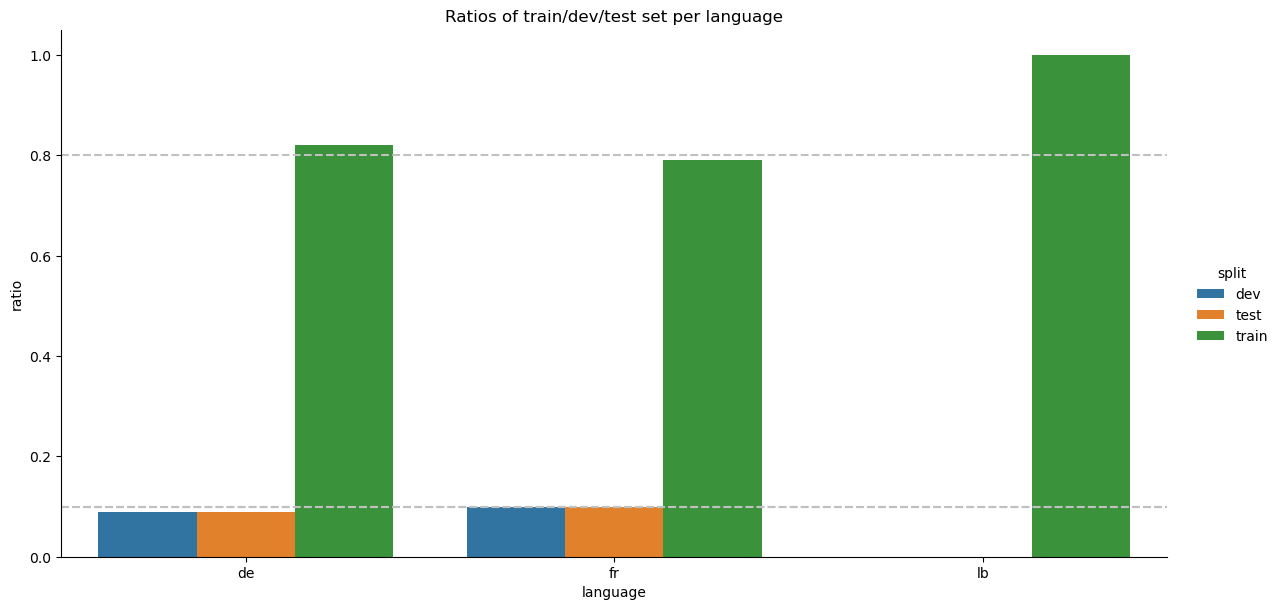

In [46]:
tdt_per_la = tdt_split_per_column(sample_all, "language", "uid")

graph = sns.catplot(x = "language", y = "ratio", hue = "split", data = tdt_per_la, kind = "bar", height=6, aspect=2)
graph.map(plt.axhline, y=train_size, color="silver", linestyle="--")
graph.map(plt.axhline, y=dev_size, color="silver", linestyle="--")
graph.map(plt.axhline, y=test_size, color="silver", linestyle="--")
plt.title("Ratios of train/dev/test set per language")
plt.show()

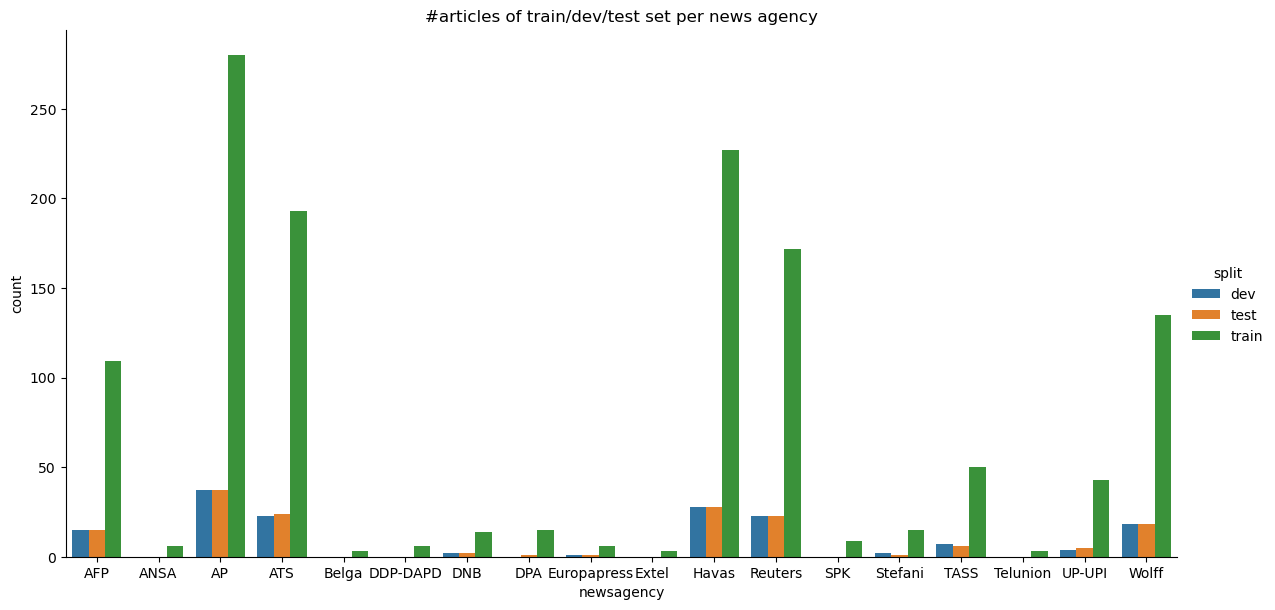

In [47]:
tdt_per_na = tdt_split_per_column(sample_all, "newsagency", "uid")

graph = sns.catplot(x = "newsagency", y = "count", hue = "split", data = tdt_per_na, kind = "bar", height=6, aspect=2)
plt.title("#articles of train/dev/test set per news agency")
plt.show()

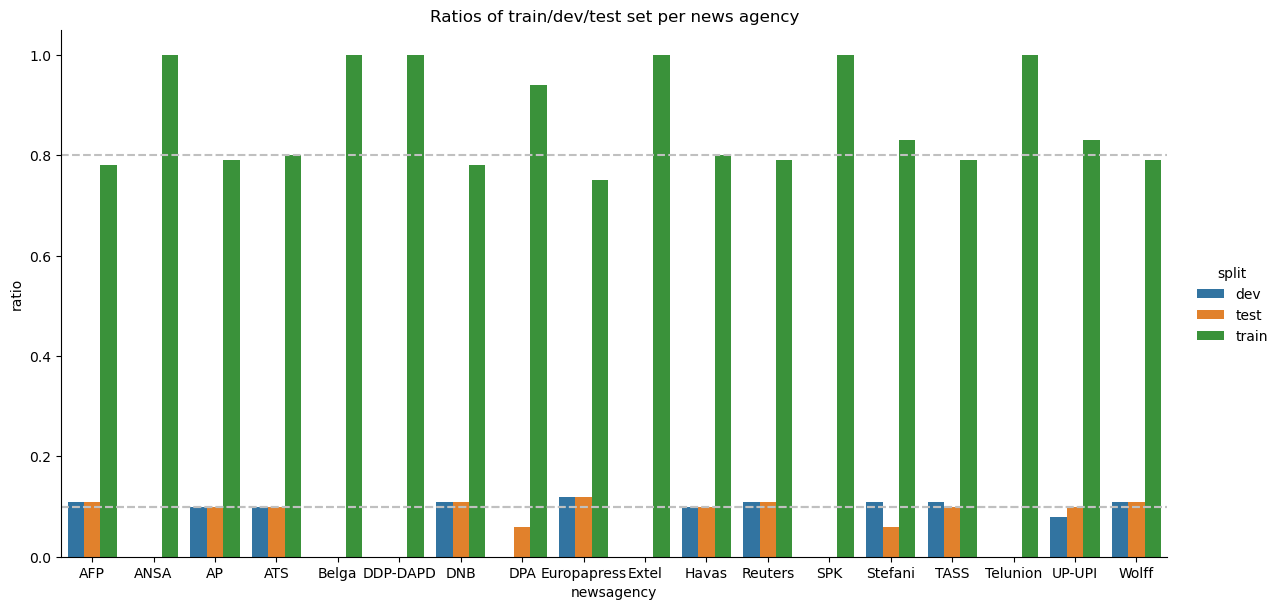

In [48]:
graph = sns.catplot(x = "newsagency", y = "ratio", hue = "split", data = tdt_per_na, kind = "bar", height=6, aspect=2)
graph.map(plt.axhline, y=train_size, color="silver", linestyle="--")
graph.map(plt.axhline, y=dev_size, color="silver", linestyle="--")
graph.map(plt.axhline, y=test_size, color="silver", linestyle="--")
plt.title("Ratios of train/dev/test set per news agency")
plt.show()

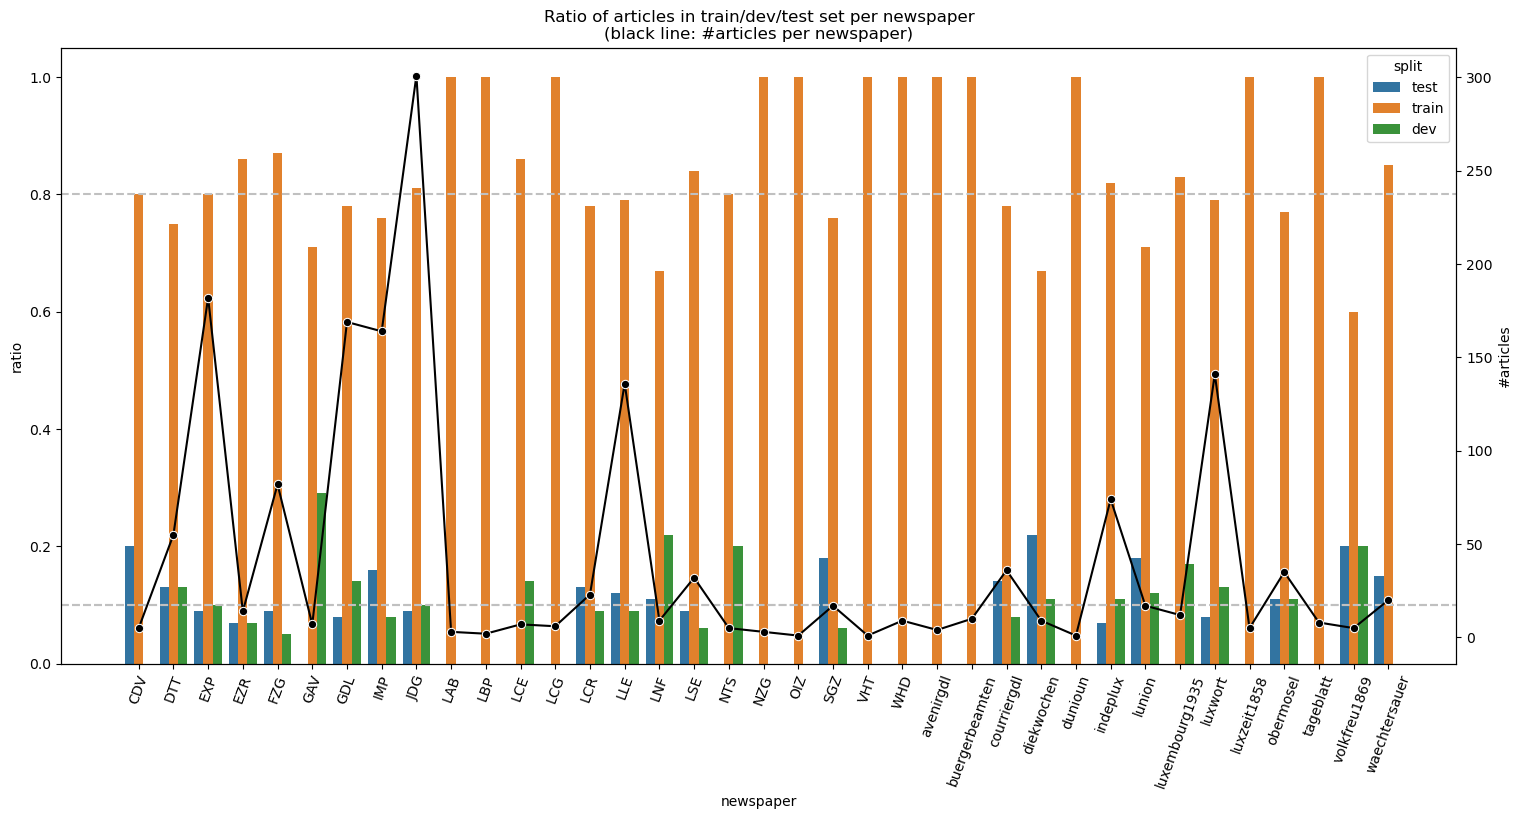

In [49]:
tdt_per_np = tdt_split_per_column(sample_all, "newspaper", "uid")
np_counts = tdt_per_np.groupby(["newspaper"]).sum()["count"].to_dict()

fig, ax1 = plt.subplots(figsize=(18,8))
ax2 = ax1.twinx()

ax1.axhline(y=train_size, color="silver", linestyle="--")
ax1.axhline(y=dev_size, color="silver", linestyle="--")
ax1.axhline(y=test_size, color="silver", linestyle="--")

sns.barplot(data = tdt_per_np, x = "newspaper", y = "ratio", hue = "split", ax=ax1)
sns.lineplot(x = np_counts.keys(), y = np_counts.values(), marker = "o", color="black", ax=ax2)


plt.title("Ratio of articles in train/dev/test set per newspaper\n(black line: #articles per newspaper)")
plt.ylabel("#articles")
ax1.tick_params(axis="x", rotation=70)
plt.show()

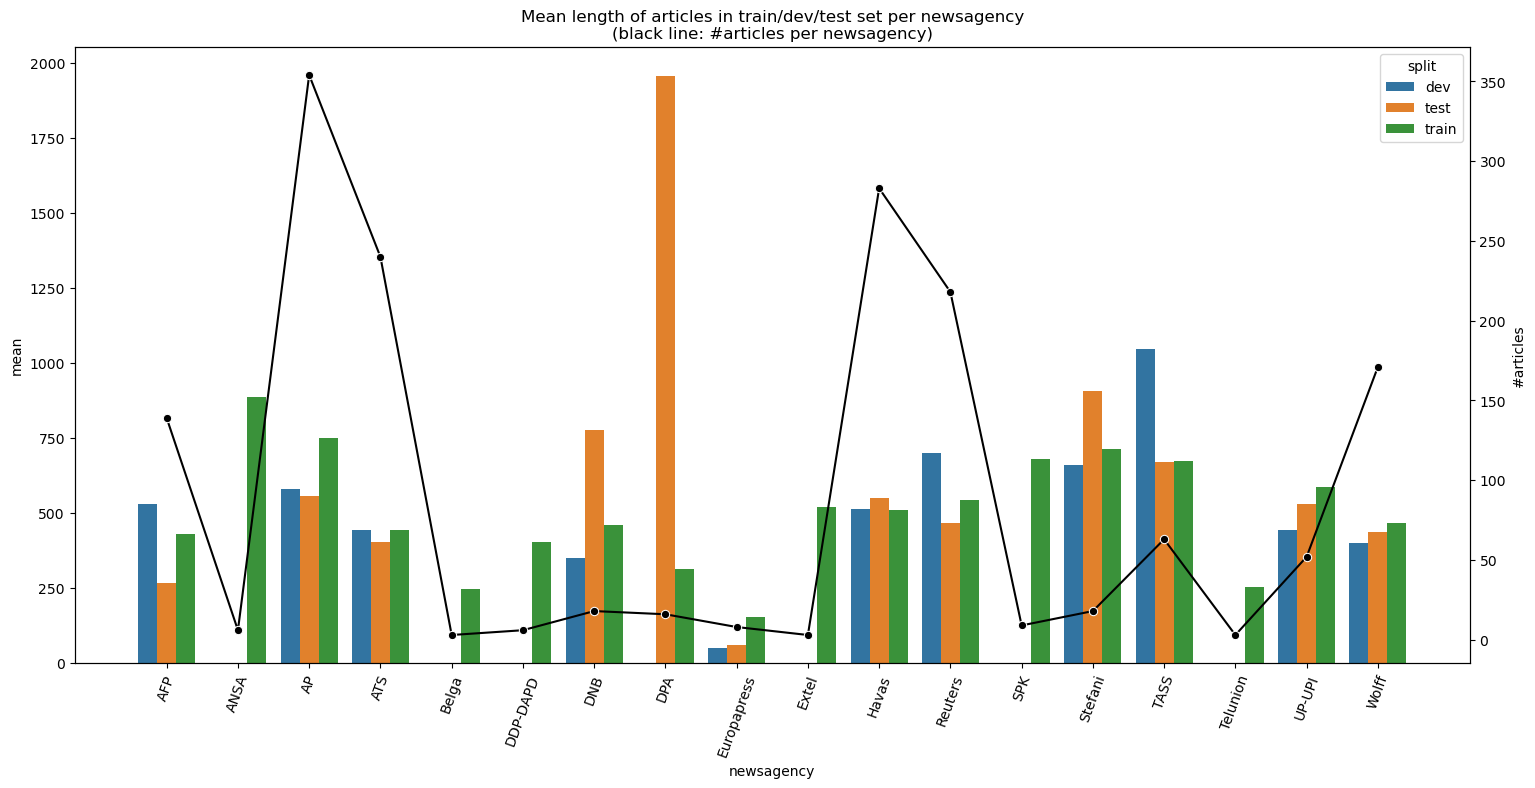

In [50]:
tdt_per_na_size = tdt_split_per_column(sample_all, "newsagency", "size", how="mean")
na_counts = tdt_per_na.groupby(["newsagency"]).sum()["count"].to_dict()

fig, ax1 = plt.subplots(figsize=(18,8))
ax2 = ax1.twinx()

sns.barplot(data = tdt_per_na_size, x = "newsagency", y = "mean", hue = "split", ax=ax1)
sns.lineplot(x = na_counts.keys(), y = na_counts.values(), marker = "o", color="black", ax=ax2)

plt.title("Mean length of articles in train/dev/test set per newsagency\n(black line: #articles per newsagency)")
plt.ylabel("#articles")
ax1.tick_params(axis="x", rotation=70)
plt.show()

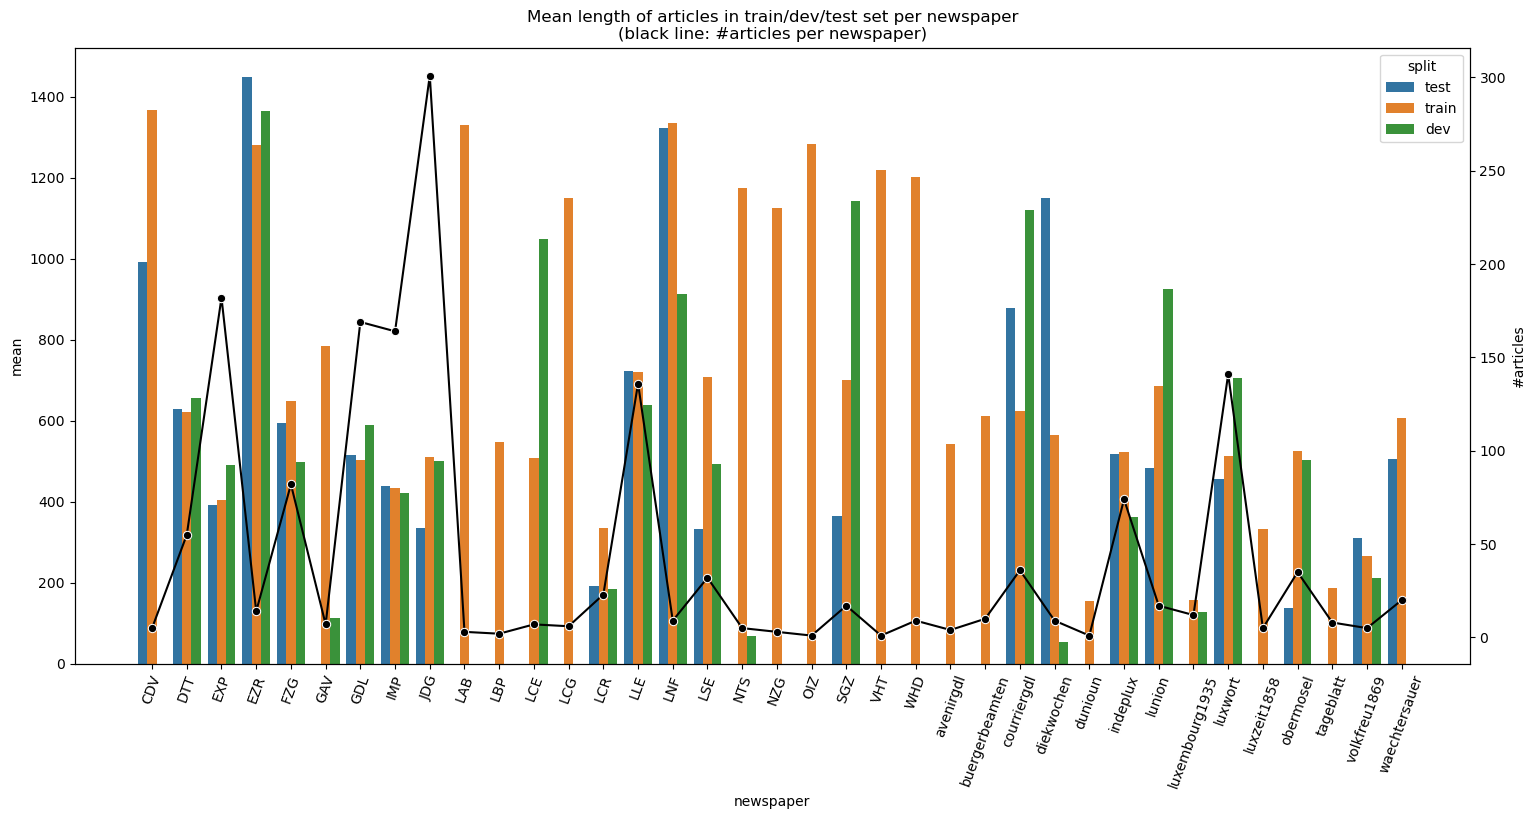

In [51]:
tdt_per_np_size = tdt_split_per_column(sample_all, "newspaper", "size", how="mean")

fig, ax1 = plt.subplots(figsize=(18,8))
ax2 = ax1.twinx()

sns.barplot(data = tdt_per_np_size, x = "newspaper", y = "mean", hue = "split", ax=ax1)
sns.lineplot(x = np_counts.keys(), y = np_counts.values(), marker = "o", color="black", ax=ax2)

plt.title("Mean length of articles in train/dev/test set per newspaper\n(black line: #articles per newspaper)")
plt.ylabel("#articles")
ax1.tick_params(axis="x", rotation=70)
plt.show()

## Distributions
- distribution of News Agencies (over time)
- distribution of Newspapers (over time)
- distribution for countries, languages

In [52]:
print(f"#articles per country:\n{sample_all['country'].value_counts()}\n")
print(f"#articles per language:\n{sample_all['language'].value_counts()}\n")

#articles per country:
CH    1233
LU     377
Name: country, dtype: int64

#articles per language:
fr    1203
de     406
lb       1
Name: language, dtype: int64



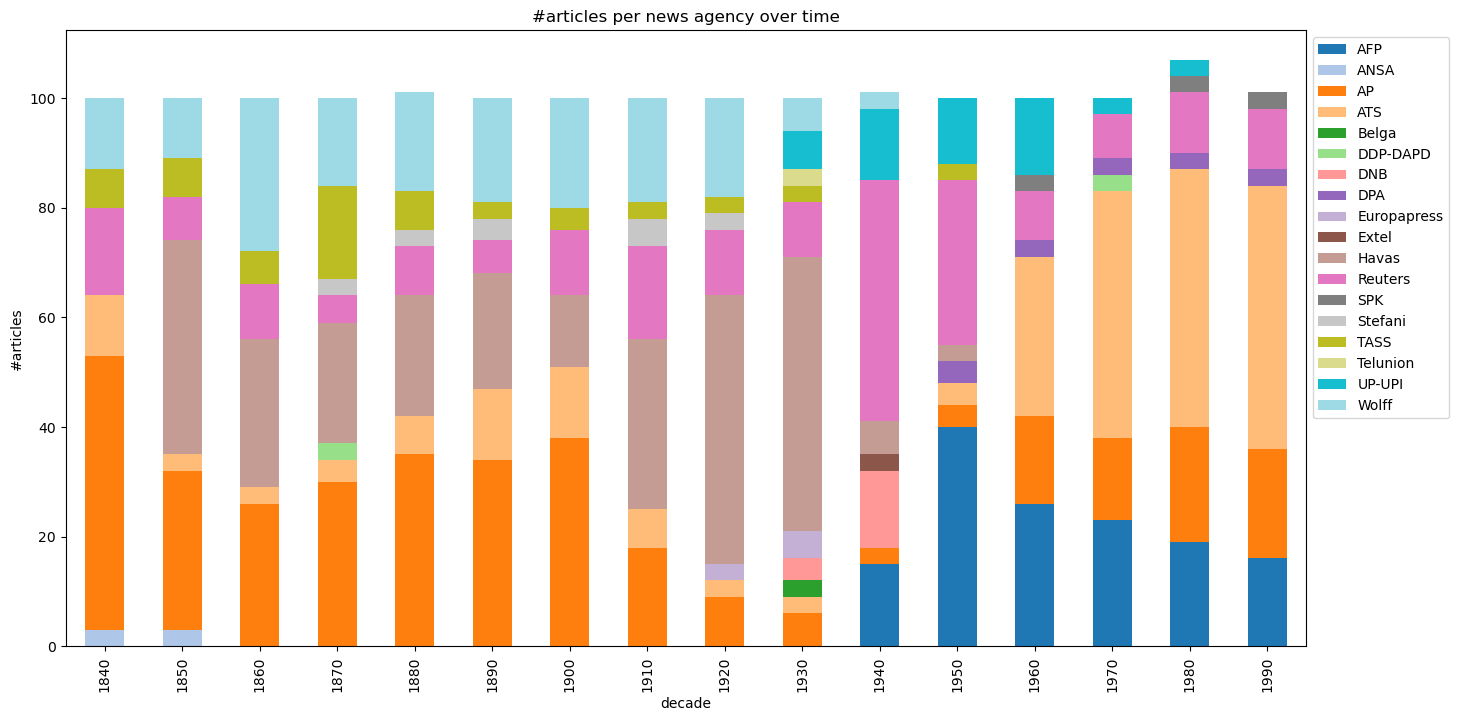

In [53]:
na_per_decade = pd.pivot_table(sample_all, index="decade", columns="newsagency", values="uid", aggfunc="count")
na_per_decade.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#articles", title="#articles per news agency over time", colormap='tab20')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

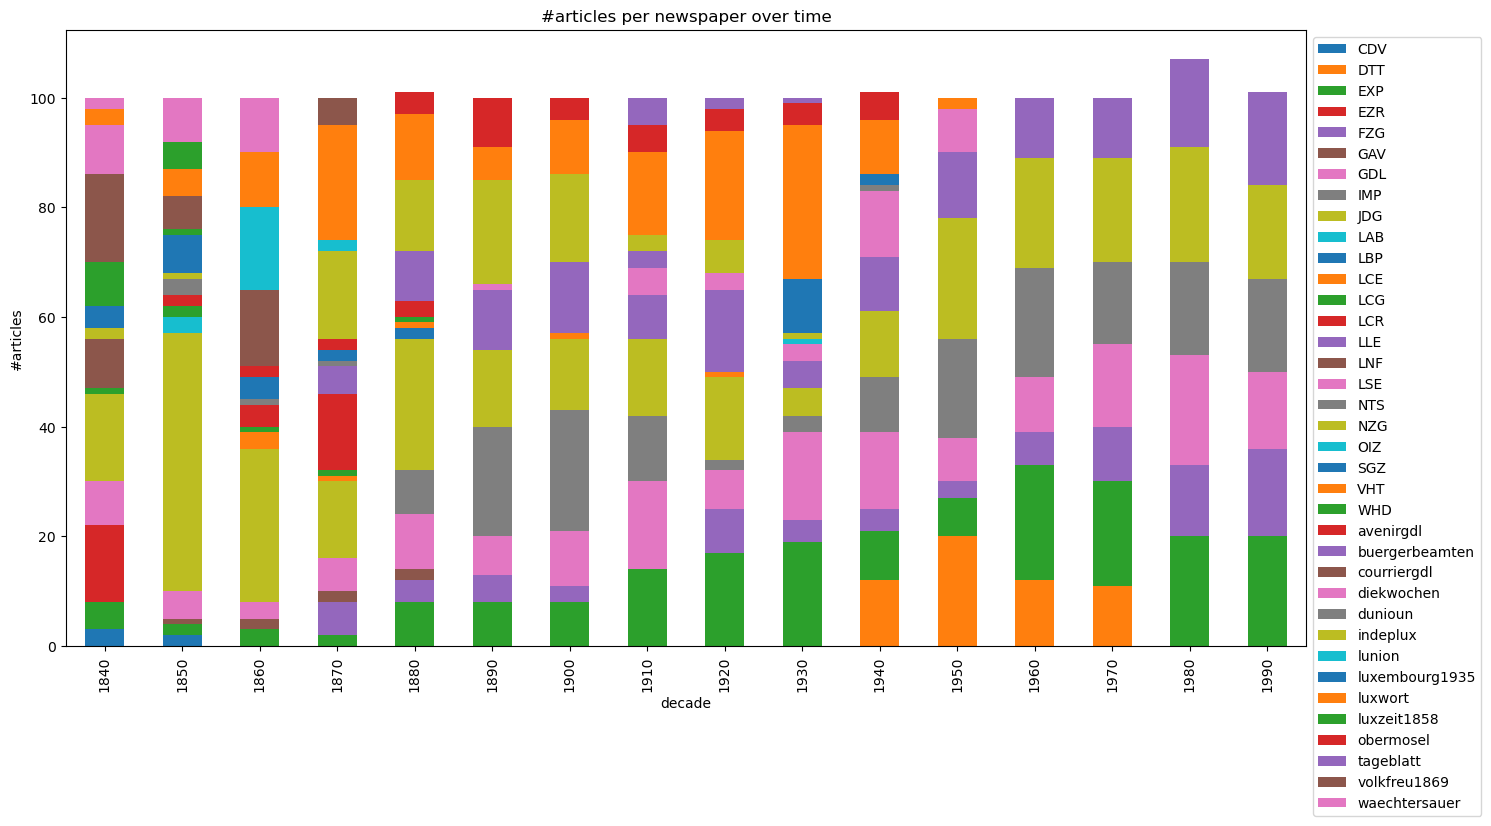

In [54]:
np_per_decade = pd.pivot_table(sample_all, index="decade", columns="newspaper", values="uid", aggfunc="count")
np_per_decade.plot(kind="bar", stacked=True, figsize=(16,8), ylabel="#articles", title="#articles per newspaper over time")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# Prepare Data for Annotation in Inception

In [55]:
#first split languages, including Luxembourgish sample in German
sample_de = sample_all.loc[sample_all["language"] == "de"]
sample_fr = sample_all.loc[(sample_all["language"] == "fr") | (sample_all["language"] == "lb")]
assert (len(sample_all) == (len(sample_de) + len(sample_fr)))

In [56]:
sample_fr[sample_fr["language"]=="lb"]

,uid,language,title,size,country,newspaper,issue,pages,nb_pages,relevance,...,content,access_right,content_provider,is_content_available,collections,decade,newsagency_list,newsagencies,newsagency,split
793,dunioun-1947-09-05-a-i0121,lb,Publicité 5 Page 8,154,LU,dunioun,dunioun-1947-09-05-a,8,1,0.0,...,NaN,Closed,BNL,NaN,local-IIV_6APb--IL_DPHu,1940,[Wolff],Wolff,Wolff,train


### Sample data for Inter-Annotator statistics

In [57]:
#Pauline
def uniform_sample(df, col, random_state, amount=3):
    return df.groupby(col, group_keys=False).apply(lambda x: x.sample(amount, random_state=random_state))

In [71]:
IA_sample_de = uniform_sample(sample_de, "decade", SEED, 3)
IA_sample_fr = uniform_sample(sample_fr, "decade", SEED, 3)

#get rest of data
core_sample_de = sample_de[~(sample_de["uid"].isin(IA_sample_de["uid"]))]
core_sample_fr = sample_fr[~(sample_fr["uid"].isin(IA_sample_fr["uid"]))]
assert(len(sample_de) == (len(IA_sample_de) + len(core_sample_de)))
assert(len(sample_fr) == (len(IA_sample_fr) + len(core_sample_fr)))

In [72]:
core_sample_de["newspaper"].value_counts()

luxwort           116
FZG                70
DTT                47
obermosel          32
waechtersauer      16
SGZ                15
EZR                13
WHD                 9
diekwochen          8
buergerbeamten      8
tageblatt           7
NTS                 5
lunion              3
NZG                 3
LAB                 2
VHT                 1
indeplux            1
volkfreu1869        1
courriergdl         1
Name: newspaper, dtype: int64

In [73]:
core_sample_fr["newspaper"].value_counts()

JDG               286
EXP               171
GDL               167
IMP               161
LLE               130
indeplux           72
courriergdl        33
LSE                28
LCR                22
lunion             13
luxembourg1935     12
luxwort            11
LNF                 8
GAV                 7
LCG                 6
LCE                 6
CDV                 5
luxzeit1858         5
avenirgdl           4
waechtersauer       3
LBP                 2
volkfreu1869        2
tageblatt           1
dunioun             1
Name: newspaper, dtype: int64

# Saving Samples

### Saving whole sample

In [62]:
sample_all.to_pickle(DATASETS_PATH + "sample_all.pkl")

### Saving UIDs with train/dev/test information

In [100]:
def save_split_as_csv(uid_splits_dict, language, out_path):
    """
    :param uid_splits_dict: of form {"train": train_df, "dev": dev_df, "test": test_df}
    :param language: "de" or "fr"
    :param path: where to store the dataframe

    saves Dataframe with columns ["uid", "split"] under "path" in csv format
    """
    data_path = out_path + f"train-dev-test_{language}.csv"

    data = pd.DataFrame()
    for split, uid_df in uid_splits_dict.items():
        split_df = uid_df.copy()
        split_df["split"] = split
        data = pd.concat([data, split_df])
    
    data.to_csv(data_path)
    print("saved file under:", data_path)

In [92]:
#first split languages, including Luxembourgish sample in French (-> is missclassified French)
train_de = df_train.loc[(df_train["language"] == "de")]
train_fr = df_train.loc[(df_train["language"] == "fr") | (df_train["language"] == "lb")]
assert (len(df_train) == (len(train_de) + len(train_fr)))

dev_de = df_dev.loc[(df_dev["language"] == "de")]
dev_fr = df_dev.loc[(df_dev["language"] == "fr") | (df_dev["language"] == "lb")]
assert (len(df_dev) == (len(dev_de) + len(dev_fr)))

test_de = df_test.loc[(df_test["language"] == "de")]
test_fr = df_test.loc[(df_test["language"] == "fr") | (df_test["language"] == "lb")]
assert (len(df_test) == (len(test_de) + len(test_fr)))

In [93]:
train_de['uid'].to_string(index=False)

'       luxwort-1933-10-23-a-i0021\n           SGZ-1871-08-26-a-i0001\n       luxwort-1875-10-25-a-i0005\n     obermosel-1886-02-23-a-i0014\n           EZR-1841-12-31-a-i0005\n waechtersauer-1854-06-21-a-i0010\n       luxwort-1902-12-29-a-i0010\nbuergerbeamten-1911-11-11-a-i0005\n       luxwort-1915-11-01-a-i0035\n       luxwort-1915-08-21-a-i0020\n       luxwort-1939-08-05-a-i0065\n waechtersauer-1863-03-15-a-i0019\n       luxwort-1924-06-02-a-i0006\n waechtersauer-1864-12-15-a-i0018\n           WHD-1845-01-24-a-i0005\n           FZG-1991-08-20-a-i0104\n     obermosel-1912-12-28-a-i0033\n           DTT-1974-02-09-a-i0047\n           SGZ-1847-11-23-a-i0003\n       luxwort-1854-04-14-a-i0012\n     obermosel-1903-06-19-a-i0022\n       luxwort-1861-12-13-a-i0006\n           SGZ-1869-07-12-a-i0006\n           DTT-1970-02-27-a-i0022\n    diekwochen-1845-08-30-a-i0008\n           VHT-1950-10-20-a-i0012\n       luxwort-1871-06-24-a-i0023\n       luxwort-1917-05-10-a-i0005\n      indeplux-1886

In [101]:
save_split_as_csv({"train": train_de[['uid']], "dev": dev_de[['uid']], "test": test_de[['uid']]}, "de", DATASETS_PATH)
save_split_as_csv({"train": train_fr[['uid']], "dev": dev_fr[['uid']], "test": test_fr[['uid']]}, "fr", DATASETS_PATH)

saved file under: datasets/train-dev-test_de.csv
saved file under: datasets/train-dev-test_fr.csv


### Saving in format used for import from S3

In [66]:
def save_as_dict(df, path):
    ''' 
    Format: {year1: {"np1": [uid1, uid2, ...], {"np2": [uid1, uid2, ...]}, 
             year2: {...}, ...}
    '''
    to_save = {year: year_group.groupby("newspaper")["uid"].apply(list).to_dict() for year, year_group in df[["uid", "year", "newspaper"]].groupby("year")}
    f = open(path, "wb")
    pickle.dump(to_save, f)
    f.close()

In [67]:
#saving test file with 2 entries
save_as_dict(IA_sample_fr[:1], DATASETS_PATH + "fr_test.pkl")

In [68]:
save_as_dict(IA_sample_de, DATASETS_PATH + 'IA_sample_de.pkl')
save_as_dict(core_sample_de, DATASETS_PATH + 'core_sample_de.pkl')
save_as_dict(IA_sample_fr, DATASETS_PATH + 'IA_sample_fr.pkl')
save_as_dict(core_sample_fr, DATASETS_PATH + 'core_sample_fr.pkl')